In [1]:
import pandas as pd
from ttrpy.trend.ema import ema
from ttrpy.trend.sma import sma

import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import talib
from sklearn.cluster import KMeans
from pandas_datareader import data as web
import scipy.spatial.distance
from datetime import datetime as dt
from matplotlib.ticker import FuncFormatter
pd.options.mode.chained_assignment = None  # default='warn'



In [2]:
df= web.get_data_yahoo('SPY',start= '1997-01-01', end='2020-01-01')
df=df[['Open','High','Low','Close']]
df['open']=df['Open'].shift(1)
df['high']=df['High'].shift(1)
df['low']=df['Low'].shift(1)
df['close']=df['Close'].shift(1)

df=df[['open','high','low','close']]
df=df.dropna()

date=df.index
df['datx']=date



In [3]:
def tsma(df, price, tsma, n):
    """
    Triple Simple Moving Average (TSMA) was designed to smooth price
    fluctuations and filter out volatility, while identify trends with the 
    lag associated with moving averages.
    The TSMA equation is a composite of a single simple moving average,
    a double simple moving average, and a triple simple moving average.
    TSMA = 3 * SMA(p, n) - 3 * SMA(SMA(p, n), n) + SMA(SMA(SMA(p, n), n), n)
    Parameters:
        df (pd.DataFrame): DataFrame which contain the asset price.
        price (string): the column name of the price of the asset.
        tsma (string): the column name for the n-day double exponential moving average results.
        n (int): the total number of periods.
    Returns:
        df (pd.DataFrame): Dataframe with n-day double exponential moving average of the asset calculated.
    """

    df = sma(df, price, tsma + "_sma", n)
    df = sma(df[n - 1 :], tsma + "_sma", tsma + "_sma_2", n)
    df = sma(df[n - 1 :], tsma + "_sma_2", tsma + "_sma_3", n)
    df[tsma] = (
        3 * df[tsma + "_sma"] - 3 * df[tsma + "_sma_2"] + df[tsma + "_sma_3"]
    )
    df = df.dropna().reset_index(drop=True)
    df.drop(
        [tsma + "_sma", tsma + "_sma_2", tsma + "_sma_3"], axis=1, inplace=True
    )

    return df


In [4]:
df = tsma(df, "close", "tsma365d", 365)


#creating new date index
df= df.rename({'open': 'Open', 'high': 'High' , 'low': 'Low','close': 'Close' ,'volume': 'Volume' ,'datx': 'Date'}, axis='columns')

cols = list(df)
cols.insert(0, cols.pop(cols.index('Date')))
df = df.loc[:, cols]
df.set_index('Date')

# build a datetime index from the date column
datetime_series = pd.to_datetime(df['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)

# replace the original index with the new one
df=df.set_index(datetime_index)


In [5]:
df['Pct Change'] = df['Close'].pct_change()
df['Criteria'] = df['Close'] >= df['tsma365d'] 


print(df['Criteria'].value_counts())

#Buy & Hold stratagy 
df['Buy & Hold'] = 100 * (1 + df['Pct Change']).cumprod()

#Triple Simple Moving Average (TEMA) trading stratagy 
df['Trend'] = 100 * (1 + ( df['Criteria'].shift(1) * df['Pct Change'] )).cumprod()


#Trend (12 month TEMA) vs. Buy & Hold
df = df.dropna()
start = df.index.min()
end = df.index.max()

False    2391
True     2304
Name: Criteria, dtype: int64


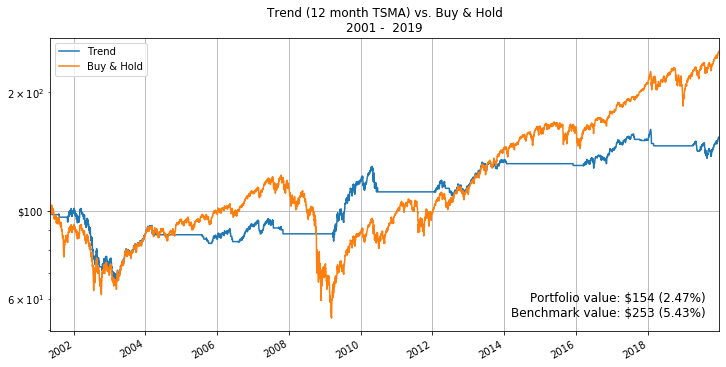

In [6]:
# Plot graph
def money(x, pos):
    'The two args are the value and tick position'
    return "${:,.0f}".format(x)

money_formatter = FuncFormatter(money)

ax = df[['Trend', 'Buy & Hold']].plot(grid=True, kind='line', title="Trend (12 month TSMA) vs. Buy & Hold\n{} -  {}".format(start.year, end.year), logy=True, figsize=(12, 6))
ax.yaxis.set_major_formatter(money_formatter)

# Print end stats
portfolio_value = df.iloc[-1]['Trend']
benchmark_value = df.iloc[-1]['Buy & Hold']
years = ((end.year - start.year - 2) * 12 + end.month - 1 + (13-start.month) ) / 12.00
portfolio_return = (((portfolio_value / 100.00) ** (1.00/years)) - 1) * 100.00
benchmark_return = (((benchmark_value / 100.00) ** (1.00/years)) - 1) * 100.00

text = 'Portfolio value: ${:,.0f} ({:,.2f}%)'.format(portfolio_value, portfolio_return)
text += "\n" + 'Benchmark value: ${:,.0f} ({:,.2f}%)'.format(benchmark_value, benchmark_return)
ax.text(0.98, 0.04, text,verticalalignment='bottom', horizontalalignment='right',transform=ax.transAxes,color='black', fontsize=12)

plt.show()

